# Bootstrap

In [ ]:
# === Bootstrap: importa só se faltarem + helpers reutilizáveis ===
import importlib

def _ensure(alias: str, module: str):
    if alias in globals():
        return globals()[alias]
    m = importlib.import_module(module)
    globals()[alias] = m
    return m

pd  = _ensure('pd', 'pandas')
np  = _ensure('np', 'numpy')

# gráficos só se forem usados depois
try:
    sns  # noqa: F821
except NameError:
    try:
        sns = importlib.import_module('seaborn')
        globals()['sns'] = sns
    except Exception:
        pass
try:
    plt  # noqa: F821
except NameError:
    try:
        import matplotlib.pyplot as plt
        globals()['plt'] = plt
    except Exception:
        pass

# helpers
if 'find_col_by_patterns' not in globals():
    import re
    from typing import Iterable, Optional
    def find_col_by_patterns(columns: Iterable[str], patterns: Iterable[str]) -> Optional[str]:
        for c in columns:
            norm = re.sub(r"[\s_\-]", "", c, flags=re.I).lower()
            if any(p in norm for p in patterns):
                return c
        return None

pd.options.display.max_colwidth = 120

# Extração (API GitHub → DataFrame)

In [ ]:
# === Extração mínima (Parte 1) ===================================
import json, requests

API_URL = "https://github.com/ingridcristh/challenge2-data-science/blob/main/TelecomX_Data.json"

if 'to_raw_github_url' not in globals():
    def to_raw_github_url(url: str) -> str:
        if "raw.githubusercontent.com" in url:
            return url
        if "github.com" in url and "/blob/" in url:
            return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
        return url

if 'load_json_from_api' not in globals():
    def load_json_from_api(url: str, timeout: int = 30):
        raw_url = to_raw_github_url(url)
        resp = requests.get(raw_url, timeout=timeout)
        resp.raise_for_status()
        try:
            return resp.json()
        except ValueError:
            return json.loads(resp.text)

data = load_json_from_api(API_URL)
df = pd.DataFrame(data) if isinstance(data, list) else pd.json_normalize(data)

print("✅ Extração OK:", df.shape)
display(df.head(3))

✅ Extração OK: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': '...","{'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 65.6, 'T..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 9}","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'N...","{'Contract': 'Month-to-month', 'PaperlessBilling': 'No', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 59...."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 4}","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'Yes', 'TechSup...","{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'Charges': {'Monthly'..."


# Transformação essencial (flatten + normalizações)

In [ ]:
# === Transformação essencial (Parte 1) ===========================
# - achatar colunas dict (customer, phone, internet, account)
# - normalizar churn
# - converter números texto -> numéricos
# - criar Contas_Diarias (se houver MonthlyCharges)
# - remover duplicatas por ID

def _flatten_dict_columns(df_in: pd.DataFrame, frac_threshold: float = 0.5):
    df_out = df_in.copy()
    dict_cols = []
    for c in list(df_out.columns):
        s = df_out[c].dropna()
        if len(s) == 0:
            continue
        frac_dict = s.apply(lambda x: isinstance(x, dict)).mean()
        if frac_dict >= frac_threshold:
            dict_cols.append(c)
            expanded = pd.json_normalize(df_out[c]).add_prefix(f"{c}_")
            df_out = df_out.drop(columns=[c]).reset_index(drop=True).join(expanded)
    return df_out, dict_cols

def _auto_cast_numeric(df_in: pd.DataFrame, frac_threshold: float = 0.7) -> pd.DataFrame:
    df_out = df_in.copy()
    for c in df_out.columns:
        if df_out[c].dtype == "object":
            s = df_out[c].astype(str).str.strip().replace({"": None})
            # 1.234,56 -> 1234.56
            s2 = s.str.replace(r"\.", "", regex=True).str.replace(",", ".", regex=False)
            conv = pd.to_numeric(s2, errors="coerce")
            if conv.notna().mean() >= frac_threshold:
                df_out[c] = conv
    return df_out

def _normalize_churn(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.lower()
    map_yes = {"yes","y","sim","true","1"}
    map_no  = {"no","n","nao","não","false","0"}
    def norm(v):
        if v in map_yes: return "Yes"
        if v in map_no:  return "No"
        if v in {"nan","none",""}: return "Desconhecido"
        if v.isdigit(): return "Desconhecido"
        return v.capitalize() if v in {"yes","no"} else v
    out = s.map(norm)
    return out.where(out.isin(["Yes","No","Desconhecido"]), "Desconhecido")

# 1) flatten
df_flat, flattened = _flatten_dict_columns(df, frac_threshold=0.5)

# 2) auto cast numérico
df_flat = _auto_cast_numeric(df_flat, frac_threshold=0.7)

# 3) churn e id
churn_col = find_col_by_patterns(df_flat.columns, ["churn","evas","cancel","saida","aband","deslig"]) or "Churn"
if churn_col not in df_flat.columns:
    df_flat["Churn"] = "Desconhecido"
    churn_col = "Churn"
else:
    df_flat["Churn"] = _normalize_churn(df_flat[churn_col])
    churn_col = "Churn"

id_col = find_col_by_patterns(df_flat.columns, ["customerid","clienteid","idcliente","id_cliente","id"])

# 4) Contas_Diarias (se houver MonthlyCharges)
monthly_col = find_col_by_patterns(
    df_flat.columns,
    ["monthlycharges","monthly_charge","charges","mensal","faturamento","cobranca","account_monthlycharges"]
)
if monthly_col and monthly_col in df_flat.columns:
    if not pd.api.types.is_numeric_dtype(df_flat[monthly_col]):
        s = df_flat[monthly_col].astype(str).str.replace(r"\.", "", regex=True).str.replace(",", ".", regex=False)
        df_flat[monthly_col] = pd.to_numeric(s, errors="coerce")
    df_flat["Contas_Diarias"] = (df_flat[monthly_col] / 30.0).round(2)

# 5) remover duplicatas
if id_col and id_col in df_flat.columns:
    before = len(df_flat)
    df_trf = df_flat.drop_duplicates(subset=[id_col], keep="first")
    removed = before - len(df_trf)
else:
    df_trf = df_flat.drop_duplicates(keep="first")
    removed = len(df_flat) - len(df_trf)

print(f"🔧 Flatten: {flattened}")
print(f"🎯 churn_col={churn_col} | id_col={id_col} | monthly_col={monthly_col}")
print(f"🧹 Duplicatas removidas: {removed}")
print("✅ Transformação OK:", df_trf.shape)
display(df_trf.head(3))

🔧 Flatten: ['customer', 'phone', 'internet', 'account']
🎯 churn_col=Churn | id_col=customerID | monthly_col=account_Charges.Monthly
🧹 Duplicatas removidas: 0
✅ Transformação OK: (7267, 22)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total,Contas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,5933.0,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,5424.0,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,28085.0,2.46


# Carga (salvar CSV/Parquet)

In [ ]:
# === Carga (Parte 1) =============================================
import os
SAVE_DIR = "data"
os.makedirs(SAVE_DIR, exist_ok=True)
csv_path = os.path.join(SAVE_DIR, "telecomx_clean.csv")
parq_path = os.path.join(SAVE_DIR, "telecomx_clean.parquet")

df_trf.to_csv(csv_path, index=False)
print("💾 CSV salvo em:", csv_path)
try:
    df_trf.to_parquet(parq_path, index=False)
    print("💾 Parquet salvo em:", parq_path)
except Exception as e:
    print("(Parquet pulado)", e)

💾 CSV salvo em: data/telecomx_clean.csv
💾 Parquet salvo em: data/telecomx_clean.parquet


# Carregar CSV (com fallback para df_trf)

In [ ]:
# Card 1 — Carregar CSV tratado (fallback para df_trf em memória)
DATA_PATH = "data/telecomx_clean.csv"

try:
    df_ml = pd.read_csv(DATA_PATH, low_memory=False)
    print("✅ CSV carregado:", DATA_PATH, "| shape:", df_ml.shape)
except FileNotFoundError:
    print("⚠️ CSV não encontrado; usando df_trf em memória.")
    try:
        df_ml = df_trf.copy()
    except NameError:
        raise RuntimeError("Nem CSV nem df_trf disponíveis. Execute as células da Parte 1.")

# target (Churn) e ID
LABEL = find_col_by_patterns(df_ml.columns, ["churn","evas","cancel","saida","aband","deslig"]) or "Churn"
if LABEL not in df_ml.columns:
    raise RuntimeError("Coluna de target (Churn) não encontrada.")

valid = df_ml[LABEL].astype(str).str.title().isin(["Yes","No"])
df_ml = df_ml.loc[valid].copy()
df_ml[LABEL] = df_ml[LABEL].astype(str).str.title()

ID_COL = find_col_by_patterns(df_ml.columns, ["customerid","clienteid","idcliente","id_cliente","id"])
print("🎯 LABEL:", LABEL, "| ID_COL:", ID_COL)
display(df_ml.head(3))

✅ CSV carregado: data/telecomx_clean.csv | shape: (7267, 22)
🎯 LABEL: Churn | ID_COL: customerID


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total,Contas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,5933.0,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,5424.0,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,28085.0,2.46


# Remover colunas irrelevantes

In [ ]:
# Card 2 — Remoção de colunas irrelevantes
drop_cols = []
if ID_COL and ID_COL in df_ml.columns:
    drop_cols.append(ID_COL)

# colunas textuais quase únicas (potenciais identificadores)
hc = []
for c in df_ml.columns:
    if c in (LABEL, ID_COL):
        continue
    if df_ml[c].dtype == 'O':
        nun = df_ml[c].nunique(dropna=True)
        if nun / len(df_ml) >= 0.98:
            hc.append(c)

MANUAL_DROPS = [
    # "coluna_que_voce_nao_quer"
]

drop_cols = list(dict.fromkeys(drop_cols + hc + MANUAL_DROPS))
print("🧽 Removendo:", drop_cols if drop_cols else "—")

df_feat = df_ml.drop(columns=drop_cols) if drop_cols else df_ml.copy()
print("Shape pós-drop:", df_feat.shape)

🧽 Removendo: ['customerID']
Shape pós-drop: (7043, 21)


# Encoding (One-Hot)

In [ ]:
# Card 3 — One-Hot nas categóricas
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

y = df_feat[LABEL].map({"No":0, "Yes":1}).astype("int8")
X_raw = df_feat.drop(columns=[LABEL])

cat_cols = X_raw.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
print(f"🔤 Categóricas ({len(cat_cols)}):", cat_cols)
print(f"🔢 Numéricas ({len(num_cols)}):", num_cols)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

print("✅ Preprocessor (OHE+passthrough) criado.")

🔤 Categóricas (15): ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']
🔢 Numéricas (5): ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'Contas_Diarias']
✅ Preprocessor (OHE+passthrough) criado.


# Proporção de churn + split + balanceamento opcional

In [ ]:
# Card 4 — Proporção de churn
dist = y.value_counts().rename({0:"No",1:"Yes"}).to_frame("count")
dist["percent"] = (dist["count"] / dist["count"].sum() * 100).round(2)
print("🎯 Distribuição do target:")
display(dist)

# split e aplicação do preprocessor
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(X_train.shape[1])])

print("Shapes:", X_train.shape, y_train.shape, "|", X_test.shape, y_test.shape)

# Card 5 — Balanceamento (opcional)
DO_BALANCE = False           # ← True para ativar
BALANCE_METHOD = "SMOTE"     # "SMOTE" ou "UNDER"

if DO_BALANCE:
    try:
        from imblearn.over_sampling import SMOTE
        from imblearn.under_sampling import RandomUnderSampler
        sampler = SMOTE(random_state=42) if BALANCE_METHOD.upper()=="SMOTE" else RandomUnderSampler(random_state=42)
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print(f"✅ Balanceado com {BALANCE_METHOD}. Novo shape:", X_train.shape, y_train.shape)
    except Exception as e:
        print("⚠️ Balanceamento não aplicado:", e, "| Sugestão: pip install imbalanced-learn")
else:
    print("ℹ️ Balanceamento desativado (considere class_weight nos modelos).")

🎯 Distribuição do target:


,count,percent
Churn,,
No,5174,73.46
Yes,1869,26.54


Shapes: (5634, 46) (5634,) | (1409, 46) (1409,)
ℹ️ Balanceamento desativado (considere class_weight nos modelos).


# Normalização/Padronização (se necessário)

In [ ]:
# Card 6 — Escalonamento opcional: recria preprocessor com scaler nas numéricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

APPLY_SCALING = None    # opções: None | "standard" | "minmax"

if APPLY_SCALING in (None, "standard", "minmax"):
    scaler = StandardScaler() if APPLY_SCALING=="standard" else (MinMaxScaler() if APPLY_SCALING=="minmax" else None)
    try:
        ohe2 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe2 = OneHotEncoder(handle_unknown="ignore", sparse=False)

    num_step = scaler if scaler is not None else "passthrough"
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", ohe2, cat_cols),
            ("num", num_step, num_cols),
        ],
        remainder="drop"
    )

    X_train = preprocessor.fit_transform(X_train_raw)
    X_test  = preprocessor.transform(X_test_raw)
    try:
        feature_names = preprocessor.get_feature_names_out()
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(X_train.shape[1])])

    print(f"✅ Preprocessor com scaling={APPLY_SCALING or 'none'} | X_train: {X_train.shape}")
else:
    raise ValueError("APPLY_SCALING deve ser None, 'standard' ou 'minmax'.")

✅ Preprocessor com scaling=none | X_train: (5634, 46)


# Análise de Correlação (numéricas + foco no churn)

,customer_SeniorCitizen,customer_tenure,account_Charges.Monthly,account_Charges.Total,Contas_Diarias
customer_SeniorCitizen,1.000000,0.016567,0.220173,0.090775,0.220147
customer_tenure,0.016567,1.000000,0.247900,0.534780,0.247910
account_Charges.Monthly,0.220173,0.247900,1.000000,0.427761,0.999996
account_Charges.Total,0.090775,0.534780,0.427761,1.000000,0.427787
Contas_Diarias,0.220147,0.247910,0.999996,0.427787,1.000000


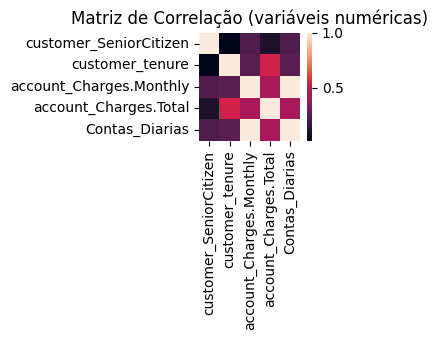

,corr_with_churn
customer_tenure,-0.352229
Contas_Diarias,0.193412
account_Charges.Monthly,0.193356
customer_SeniorCitizen,0.150889
account_Charges.Total,-0.123433


In [ ]:
# Card 7 — Matriz de correlação (apenas variáveis numéricas) + correlação com o churn

# --- helper: tenta converter objetos "numéricos" para float quando fizer sentido
def _auto_cast_numeric(df_in: pd.DataFrame, frac_threshold: float = 0.6) -> pd.DataFrame:
    df_out = df_in.copy()
    for c in df_out.columns:
        if df_out[c].dtype == "object":
            s = df_out[c].astype(str).str.strip().replace({"": None})
            # trata formato 1.234,56 -> 1234.56 e 1,234.56 -> 1234.56 de forma conservadora
            s2 = s.str.replace(r"(?<=\d)\.(?=\d{3}\b)", "", regex=True)  # remove ponto de milhar
            s2 = s2.str.replace(",", ".", regex=False)                   # vírgula -> ponto
            conv = pd.to_numeric(s2, errors="coerce")
            if conv.notna().mean() >= frac_threshold:
                df_out[c] = conv
    return df_out

# Seleciona numéricas; se não houver, tenta auto-cast
df_num = df_feat.select_dtypes(include=[np.number]).copy()
if df_num.shape[1] == 0:
    df_num = _auto_cast_numeric(df_feat).select_dtypes(include=[np.number]).copy()

if df_num.shape[1] == 0:
    print("⚠️ Não há colunas numéricas suficientes para a matriz de correlação.")
else:
    # Matriz de correlação entre numéricas
    corr_num = df_num.corr()
    display(corr_num)

    # Heatmap (se seaborn estiver disponível)
    try:
        plt.figure(figsize=(min(12, 1 + 0.5*len(df_num.columns)), min(10, 1 + 0.5*len(df_num.columns))))
        sns.heatmap(corr_num, annot=False)
        plt.title("Matriz de Correlação (variáveis numéricas)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Heatmap não gerado:", e)

    # Correlação de cada numérica com o alvo (point-biserial = Pearson com y binário)
    # y já foi definido antes como 0/1 a partir de df_feat[LABEL]
    if 'y' in globals() and len(y) == len(df_feat):
        corr_with_y = {}
        for c in df_num.columns:
            # alinha e ignora NaN
            s = df_num[c]
            m = s.notna() & y.notna()
            if m.any():
                try:
                    corr_with_y[c] = s[m].corr(y[m])
                except Exception:
                    pass
        if corr_with_y:
            corr_target = (pd.Series(corr_with_y)
                           .sort_values(key=lambda x: x.abs(), ascending=False)
                           .to_frame("corr_with_churn"))
            display(corr_target.head(15))
        else:
            print("⚠️ Não foi possível calcular correlação com o target (verifique y).")
    else:
        print("⚠️ Vetor y (target binário) não encontrado ou desalinhado.")

# Análises Direcionadas (Tenure × Churn; TotalCharges × Churn, etc.)

🎯 Selecionadas → tenure: customer_tenure | total: account_Charges.Total | monthly: account_Charges.Monthly | daily: Contas_Diarias


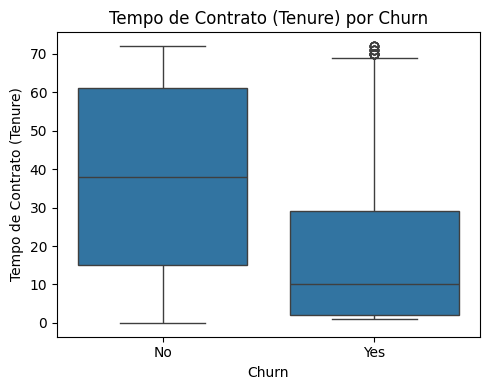

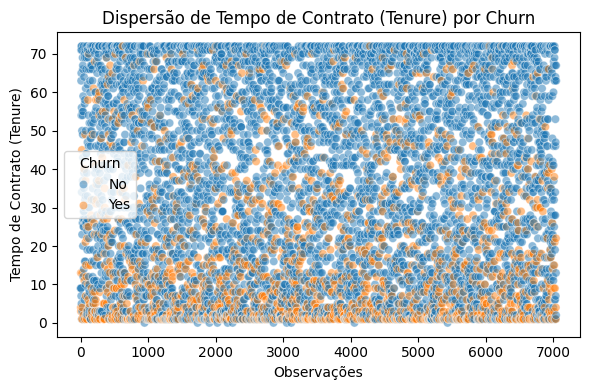

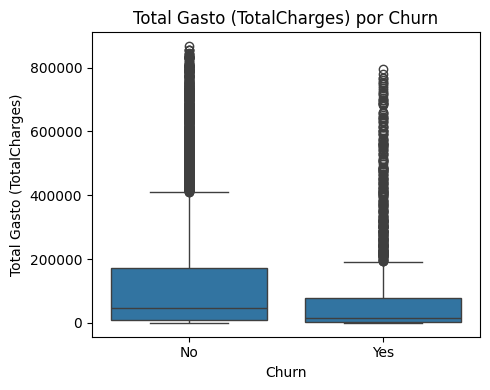

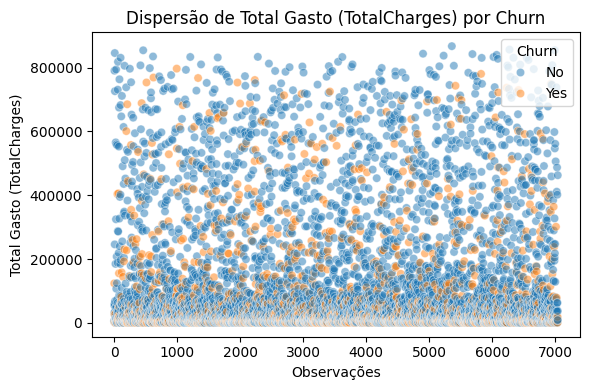

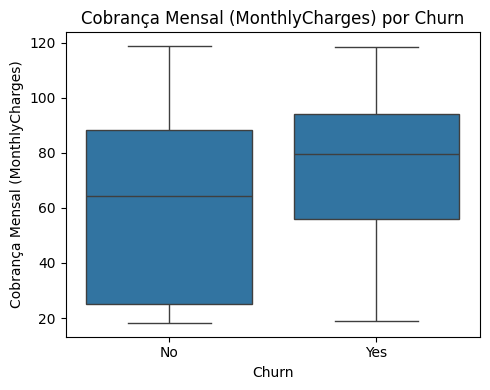

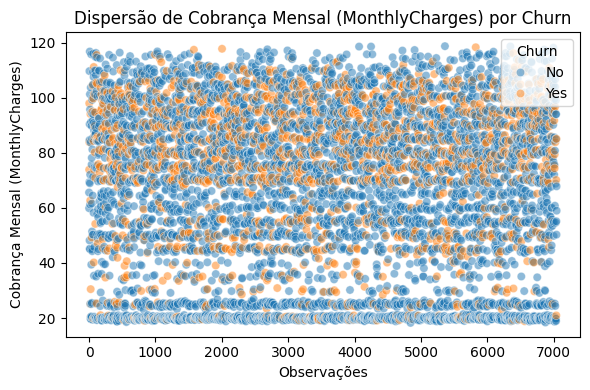

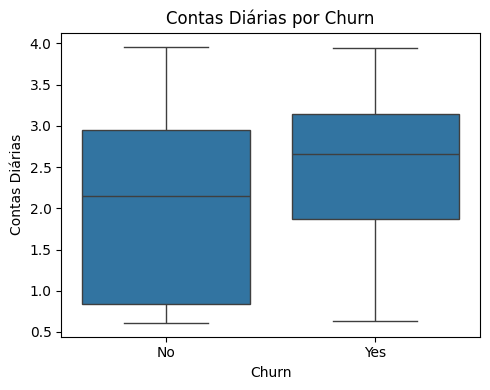

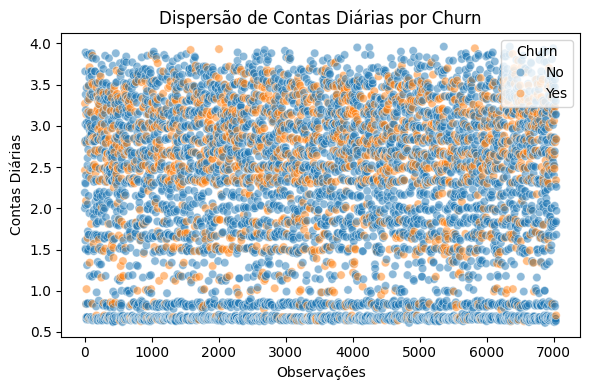

In [ ]:
# Card 8 — Análises direcionadas com boxplot/dispersion por Churn

# Detecta colunas candidatas por padrão (reuso do helper find_col_by_patterns)
tenure_col  = find_col_by_patterns(df_feat.columns, ["tenure", "tempo", "meses"])
total_col   = find_col_by_patterns(df_feat.columns, ["totalcharges", "total_charge", "total"])
monthly_col = find_col_by_patterns(df_feat.columns, ["monthlycharges", "monthly_charge", "charges", "mensal"])
daily_col   = "Contas_Diarias" if "Contas_Diarias" in df_feat.columns else None

print("🎯 Selecionadas →",
      "tenure:", tenure_col, "| total:", total_col, "| monthly:", monthly_col, "| daily:", daily_col)

# helper: garantir que a coluna esteja numérica (conversão leve, sem forçar se a maioria não converter)
def _ensure_numeric_col(df_in: pd.DataFrame, col: str) -> bool:
    if not col or col not in df_in.columns:
        return False
    if pd.api.types.is_numeric_dtype(df_in[col]):
        return True
    s = df_in[col].astype(str).str.strip().replace({"": None})
    s2 = s.str.replace(r"(?<=\d)\.(?=\d{3}\b)", "", regex=True)
    s2 = s2.str.replace(",", ".", regex=False)
    conv = pd.to_numeric(s2, errors="coerce")
    if conv.notna().mean() >= 0.6:
        df_in[col] = conv
        return True
    return False

# Garante numérico nas variáveis de interesse
for c in [tenure_col, total_col, monthly_col, daily_col]:
    if c:
        _ensure_numeric_col(df_feat, c)

# Ordem fixa para eixo do churn
order_churn = [x for x in ["No","Yes"] if x in df_feat[LABEL].unique()]

def box_and_scatter(col: str, nice_name: str):
    if not col or col not in df_feat.columns:
        print(f"⚠️ Coluna '{nice_name}' não encontrada.")
        return
    if not pd.api.types.is_numeric_dtype(df_feat[col]):
        print(f"⚠️ Coluna '{nice_name}' não é numérica; pulando.")
        return

    # Boxplot por churn
    try:
        plt.figure(figsize=(5,4))
        sns.boxplot(data=df_feat, x=LABEL, y=col, order=order_churn if order_churn else None)
        plt.title(f"{nice_name} por Churn")
        plt.xlabel("Churn"); plt.ylabel(nice_name)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Boxplot não gerado para {nice_name}:", e)

    # Dispersão (valor vs. índice) segmentada por churn (para ver distribuição)
    try:
        tmp = df_feat[[LABEL, col]].reset_index(drop=True).copy()
        tmp["idx"] = tmp.index
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=tmp, x="idx", y=col, hue=LABEL, hue_order=order_churn if order_churn else None, alpha=0.5)
        plt.title(f"Dispersão de {nice_name} por Churn")
        plt.xlabel("Observações"); plt.ylabel(nice_name)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Scatter não gerado para {nice_name}:", e)

# Executa análises sugeridas
box_and_scatter(tenure_col,  "Tempo de Contrato (Tenure)")
box_and_scatter(total_col,   "Total Gasto (TotalCharges)")

# Extras úteis, se existirem:
if monthly_col: box_and_scatter(monthly_col, "Cobrança Mensal (MonthlyCharges)")
if daily_col:   box_and_scatter(daily_col,   "Contas Diárias")

# Separação de Dados (train/test com estratificação)

In [ ]:
# Card 9 — Split treino/teste com estratificação (mude TEST_SIZE se quiser 70/30)
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2  # 0.3 para 70/30; 0.2 para 80/20
RANDOM_STATE = 42

# garante y binário e X bruto (sem encoding ainda)
y = df_feat[LABEL].map({"No": 0, "Yes": 1}).astype("int8")
X_raw = df_feat.drop(columns=[LABEL])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"✅ Split concluído | TEST_SIZE={TEST_SIZE}")
print("Treino:", X_train_raw.shape, "| Teste:", X_test_raw.shape)
print("Distribuição treino:", dict(y_train.value_counts().rename({0:"No",1:"Yes"})))
print("Distribuição teste :", dict(y_test.value_counts().rename({0:"No",1:"Yes"})))

✅ Split concluído | TEST_SIZE=0.2
Treino: (5634, 20) | Teste: (1409, 20)
Distribuição treino: {'No': np.int64(4139), 'Yes': np.int64(1495)}
Distribuição teste : {'No': np.int64(1035), 'Yes': np.int64(374)}


# Criação de Modelos (1 com normalização + 1 baseado em árvore)

In [ ]:
# Card 10 — Dois modelos com IMPUTAÇÃO para lidar com NaN
#   A) Logística (normalização): OneHot + SimpleImputer + StandardScaler + LogisticRegression
#   B) RandomForest (árvore):    OneHot + SimpleImputer + passthrough numérico + RandomForest

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# identifica colunas por tipo no X_raw (definido no split do Card 9)
cat_cols = X_raw.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
print(f"🔤 Categóricas ({len(cat_cols)}):", cat_cols)
print(f"🔢 Numéricas ({len(num_cols)}):", num_cols)

# OneHotEncoder compat (sparse_output em versões novas; sparse em antigas)
try:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Pipelines por tipo
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe_dense),
])

num_pipe_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

num_pipe_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# (A) Pipeline escalonado: OHE + imputação + scaler + LogReg
pre_scaled = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe_scaled, num_cols),
    ],
    remainder="drop"
)

clf_lr = Pipeline(steps=[
    ("pre", pre_scaled),
    ("lr", LogisticRegression(
        max_iter=2000, solver="lbfgs",
        class_weight="balanced", random_state=42
    ))
])

# (B) Pipeline árvore: OHE + imputação + passthrough + RandomForest
pre_tree = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe_tree, num_cols),
    ],
    remainder="drop"
)

clf_rf = Pipeline(steps=[
    ("pre", pre_tree),
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

# Treino
clf_lr.fit(X_train_raw, y_train)
clf_rf.fit(X_train_raw, y_train)

print("✅ Modelos treinados com imputação: LogisticRegression (scaled) e RandomForest (tree).")

🔤 Categóricas (15): ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']
🔢 Numéricas (5): ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'Contas_Diarias']
✅ Modelos treinados com imputação: LogisticRegression (scaled) e RandomForest (tree).


# Avaliação (accuracy, precisão, recall, F1, matriz de confusão)


=== Logistic Regression (scaled) ===
Acurácia (treino): 0.7522 | Acurácia (teste): 0.7452
Precisão: 0.5130 | Recall: 0.7914 | F1: 0.6225

Relatório de classificação (teste):
              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



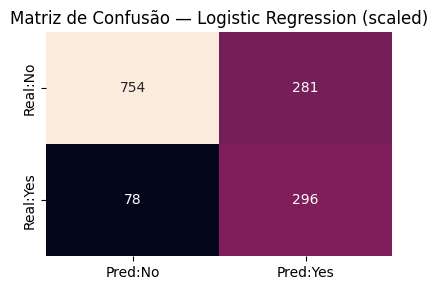


=== RandomForest (tree) ===
Acurácia (treino): 0.9977 | Acurácia (teste): 0.7771
Precisão: 0.6095 | Recall: 0.4465 | F1: 0.5154

Relatório de classificação (teste):
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.61      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.77      1409



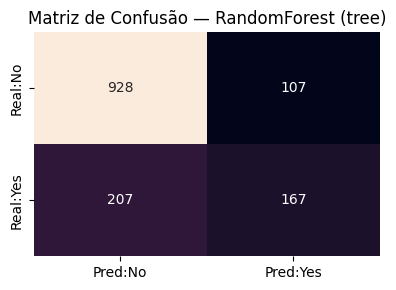


📊 Comparativo (ordenado por F1):


,acc_train,acc_test,precision,recall,f1
model,,,,,
Logistic Regression (scaled),0.752219,0.745209,0.512998,0.791444,0.622503
RandomForest (tree),0.997693,0.777147,0.609489,0.446524,0.515432


Logistic Regression (scaled): OK (sem gap relevante)
RandomForest (tree): ⚠️ possível overfitting (treino >> teste)


In [ ]:
# Card 11 — Avaliação dos dois modelos
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, Xtr, ytr, Xte, yte, name: str):
    # previsões (classe e probabilidade, se disponível)
    y_pred_tr = model.predict(Xtr)
    y_pred_te = model.predict(Xte)

    y_proba_te = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba_te = model.predict_proba(Xte)[:, 1]
        except Exception:
            y_proba_te = None

    # métricas agregadas
    acc_tr = accuracy_score(ytr, y_pred_tr)
    acc_te = accuracy_score(yte, y_pred_te)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred_te, average="binary", zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Acurácia (treino): {acc_tr:.4f} | Acurácia (teste): {acc_te:.4f}")
    print(f"Precisão: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}\n")
    print("Relatório de classificação (teste):")
    print(classification_report(yte, y_pred_te, target_names=["No","Yes"], zero_division=0))

    # matriz de confusão
    cm = confusion_matrix(yte, y_pred_te, labels=[0,1])
    cm_df = pd.DataFrame(cm, index=["Real:No","Real:Yes"], columns=["Pred:No","Pred:Yes"])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
    plt.title(f"Matriz de Confusão — {name}")
    plt.tight_layout(); plt.show()

    return {
        "model": name,
        "acc_train": acc_tr,
        "acc_test": acc_te,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

res_lr = evaluate_model(clf_lr, X_train_raw, y_train, X_test_raw, y_test, "Logistic Regression (scaled)")
res_rf = evaluate_model(clf_rf, X_train_raw, y_train, X_test_raw, y_test, "RandomForest (tree)")

# Comparativo em tabela
res_df = pd.DataFrame([res_lr, res_rf]).set_index("model").sort_values("f1", ascending=False)
print("\n📊 Comparativo (ordenado por F1):")
display(res_df)

# Observações sobre overfitting/underfitting
def overfit_flag(acc_tr, acc_te, delta=0.05):
    if acc_tr - acc_te > delta:
        return "⚠️ possível overfitting (treino >> teste)"
    if acc_te - acc_tr > delta:
        return "⚠️ possível underfitting (teste >> treino) — incomum; investigar"
    return "OK (sem gap relevante)"

for name, row in res_df.iterrows():
    print(f"{name}: {overfit_flag(row['acc_train'], row['acc_test'])}")

# Importância das Variáveis (LR + RF)

🔺 Top 15 (coeficientes positivos) — aumentam probabilidade de churn:


,feature,coef,odds_ratio
32,account_Contract_Month-to-month,0.650734,1.916947
12,internet_InternetService_Fiber optic,0.574601,1.776422
39,account_PaymentMethod_Electronic check,0.255577,1.291206
28,internet_StreamingTV_Yes,0.231309,1.260248
31,internet_StreamingMovies_Yes,0.185293,1.203571
23,internet_TechSupport_No,0.181356,1.198842
14,internet_OnlineSecurity_No,0.141335,1.151810
10,phone_MultipleLines_Yes,0.127727,1.136243
36,account_PaperlessBilling_Yes,0.084948,1.088660
41,customer_SeniorCitizen,0.077759,1.080862


🔻 Top 15 (coeficientes negativos) — reduzem probabilidade de churn:


,feature,coef,odds_ratio
42,customer_tenure,-0.818338,0.441164
34,account_Contract_Two year,-0.756112,0.469488
11,internet_InternetService_DSL,-0.523195,0.592624
35,account_PaperlessBilling_No,-0.252798,0.776624
8,phone_MultipleLines_No,-0.234170,0.791227
24,internet_TechSupport_No internet service,-0.219256,0.803116
13,internet_InternetService_No,-0.219256,0.803116
15,internet_OnlineSecurity_No internet service,-0.219256,0.803116
30,internet_StreamingMovies_No internet service,-0.219256,0.803116
27,internet_StreamingTV_No internet service,-0.219256,0.803116


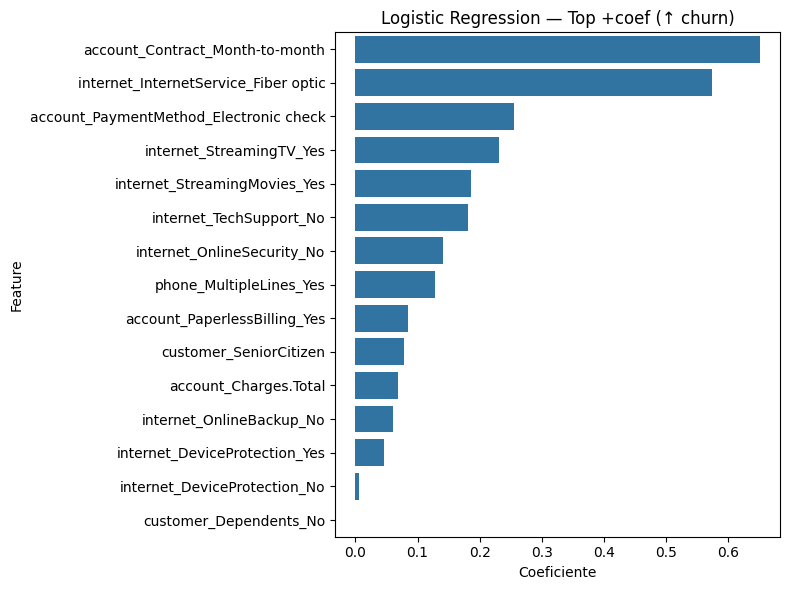

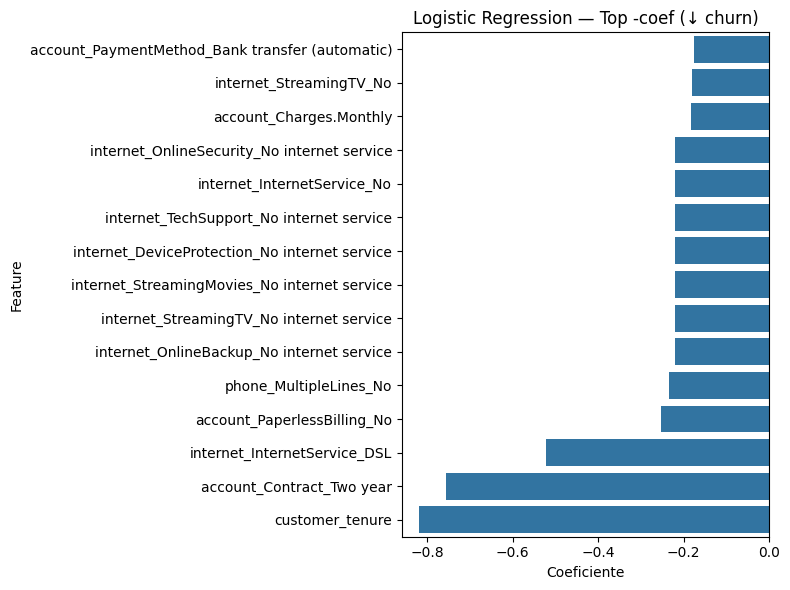

🌲 RandomForest — Top 20 importâncias:


,feature,importance
42,customer_tenure,0.134637
44,account_Charges.Total,0.113279
43,account_Charges.Monthly,0.099370
45,Contas_Diarias,0.087732
32,account_Contract_Month-to-month,0.075140
23,internet_TechSupport_No,0.034823
34,account_Contract_Two year,0.033776
14,internet_OnlineSecurity_No,0.032579
39,account_PaymentMethod_Electronic check,0.027090
12,internet_InternetService_Fiber optic,0.022996


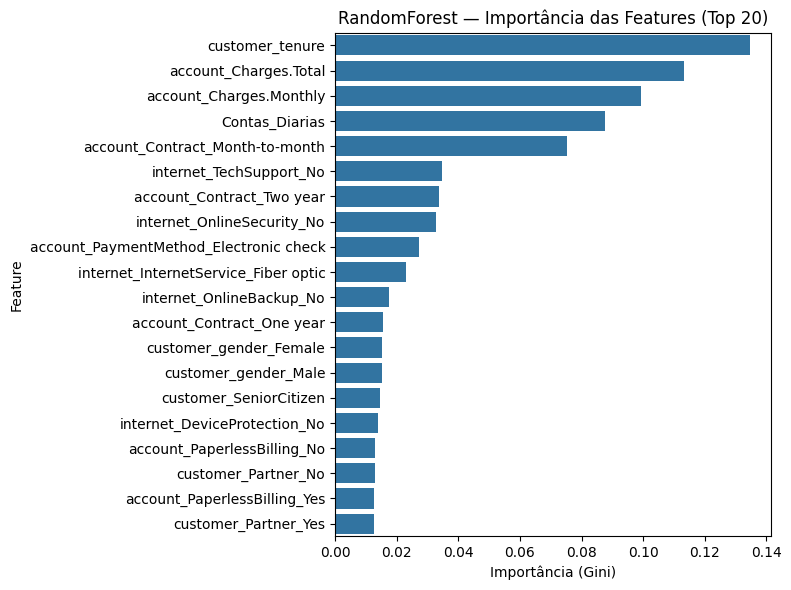

In [16]:
# Card 12 — Importância das variáveis para Logistic Regression e RandomForest

import numpy as np
import pandas as pd

try:
    plt  # noqa: F821
    sns  # noqa: F821
except NameError:
    import matplotlib.pyplot as plt
    import seaborn as sns

# --- Helpers: recuperar nomes de features do ColumnTransformer dentro do Pipeline ---
def _get_feature_names_from_pipeline(pipe) -> np.ndarray:
    """
    Tenta extrair os nomes finais das features após o 'pre' (ColumnTransformer) do pipeline.
    Retorna f0..fn como fallback.
    """
    pre = pipe.named_steps.get("pre")
    if pre is None:
        # Sem preprocessor — tentar usar atributo do estimador
        est = list(pipe.named_steps.values())[-1]
        n = getattr(est, "n_features_in_", None)
        return np.array([f"f{i}" for i in range(n or 0)])
    # 1) Tenta API moderna
    if hasattr(pre, "get_feature_names_out"):
        try:
            return pre.get_feature_names_out()
        except Exception:
            pass
    # 2) Tenta compor manualmente (cat + num)
    try:
        cat_cols = pre.transformers_[0][2]
        num_cols = pre.transformers_[1][2]
        ohe = pre.named_transformers_["cat"].named_steps.get("ohe")
        if hasattr(ohe, "get_feature_names_out"):
            cat_names = ohe.get_feature_names_out(cat_cols)
        else:
            # Fallback: usa nomes genéricos caso a versão não exponha categorias
            cat_names = np.array([f"cat_{c}" for c in cat_cols], dtype=object)
        return np.concatenate([cat_names, np.array(num_cols, dtype=object)])
    except Exception:
        est = list(pipe.named_steps.values())[-1]
        n = getattr(est, "n_features_in_", None)
        return np.array([f"f{i}" for i in range(n or 0)])

def _clean_feat_name(name: str) -> str:
    # remove prefixos do ColumnTransformer (ex.: "cat__" / "num__")
    if "__" in name:
        name = name.split("__", 1)[1]
    return name

# --- Logistic Regression: coeficientes (efeito na probabilidade de churn) ---
lr_names = _get_feature_names_from_pipeline(clf_lr)
lr_est   = clf_lr.named_steps.get("lr")
if lr_est is None:
    raise RuntimeError("Pipeline da Logística não encontrado como 'lr' no clf_lr.")

lr_coef  = lr_est.coef_.ravel()  # binário → shape (n_features,)
df_lr_imp = pd.DataFrame({
    "feature": [ _clean_feat_name(str(x)) for x in lr_names ],
    "coef": lr_coef
})
df_lr_imp["odds_ratio"] = np.exp(df_lr_imp["coef"])
df_lr_imp["abs_coef"]   = df_lr_imp["coef"].abs()

# Top que AUMENTAM churn (coeficiente positivo) e que REDUZEM churn (negativo)
top_pos = df_lr_imp.sort_values("coef", ascending=False).head(15)
top_neg = df_lr_imp.sort_values("coef", ascending=True).head(15)

print("🔺 Top 15 (coeficientes positivos) — aumentam probabilidade de churn:")
display(top_pos[["feature","coef","odds_ratio"]])

print("🔻 Top 15 (coeficientes negativos) — reduzem probabilidade de churn:")
display(top_neg[["feature","coef","odds_ratio"]])

# Gráficos LR
plt.figure(figsize=(8,6))
sns.barplot(data=top_pos, y="feature", x="coef")
plt.title("Logistic Regression — Top +coef (↑ churn)")
plt.xlabel("Coeficiente"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
sns.barplot(data=top_neg.sort_values("coef", ascending=False), y="feature", x="coef")
plt.title("Logistic Regression — Top -coef (↓ churn)")
plt.xlabel("Coeficiente"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

# --- RandomForest: feature_importances_ ---
rf_names = _get_feature_names_from_pipeline(clf_rf)
rf_est   = clf_rf.named_steps.get("rf")
if rf_est is None:
    raise RuntimeError("Pipeline da RandomForest não encontrado como 'rf' no clf_rf.")

rf_imp   = rf_est.feature_importances_
df_rf_imp = pd.DataFrame({
    "feature": [ _clean_feat_name(str(x)) for x in rf_names ],
    "importance": rf_imp
}).sort_values("importance", ascending=False)

print("🌲 RandomForest — Top 20 importâncias:")
display(df_rf_imp.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=df_rf_imp.head(20), y="feature", x="importance")
plt.title("RandomForest — Importância das Features (Top 20)")
plt.xlabel("Importância (Gini)"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

# Conclusão (relatório curto e automático)

In [17]:
# Card 13 — Conclusão automática com base nas importâncias/coeficientes

from IPython.display import Markdown, display

def _nice_list(lst, k=5):
    lst = [str(x) for x in lst][:k]
    if not lst: return "—"
    if len(lst) == 1: return lst[0]
    return ", ".join(lst[:-1]) + " e " + lst[-1]

# Coleta melhores sinais da Logística
pos_drivers = top_pos["feature"].tolist() if "top_pos" in globals() else []
neg_drivers = top_neg["feature"].tolist() if "top_neg" in globals() else []

# E os principais da RF
rf_drivers  = df_rf_imp["feature"].head(5).tolist() if "df_rf_imp" in globals() else []

# Se houver comparativo de modelos (res_df da célula de avaliação), captura o melhor por F1
best_line = ""
if "res_df" in globals():
    try:
        best_model_name = res_df.index[0]
        best_line = f"- **Melhor desempenho (F1)**: `{best_model_name}`."
    except Exception:
        pass

md = f"""
# 📌 Conclusões e Recomendações

**Resumo:** Os modelos treinados apontam variáveis com maior relação com a **evasão (churn)**.
A **Regressão Logística** evidencia sinais lineares (efeitos direcionais), e a **RandomForest** destaca variáveis com maior ganho de impureza.

{best_line}

## Principais fatores associados ao *aumento* do churn
- (Logística, coeficientes positivos): **{_nice_list(pos_drivers)}**
- (RF, importâncias): **{_nice_list(rf_drivers)}**

## Principais fatores associados à *redução* do churn
- (Logística, coeficientes negativos): **{_nice_list(neg_drivers)}**

## Interpretação
- **Coeficientes positivos** (Logística) sugerem que, mantendo as demais variáveis constantes, o aumento/presença dessas features **eleva** a chance de churn.
- **Coeficientes negativos** indicam efeito **protetivo**.
- **Importâncias da RF** apontam as variáveis que mais contribuíram para as divisões das árvores (não têm direção intrínseca, mas são bons *rankings* de relevância).

## Recomendações de retenção
- **Segmentos de risco:** priorizar clientes com os *drivers* positivos mais fortes (ex.: contrato **Month-to-month**, certos métodos de pagamento, combinações de serviços).
- **Ofertas e bundles:** reduzir churn elevando **valor percebido** (ex.: migração para contratos mais longos com benefícios, adicionar segurança/backup/tech support quando ausentes).
- **Onboarding e engajamento:** reforçar ações nos **primeiros meses** (tenure baixo).
- **Ajuste de precificação/comunicação:** revisar **cobrança mensal**/serviços com maior associação a churn; comunicação ativa antes de renovações.
"""

display(Markdown(md))


# 📌 Conclusões e Recomendações

**Resumo:** Os modelos treinados apontam variáveis com maior relação com a **evasão (churn)**.  
A **Regressão Logística** evidencia sinais lineares (efeitos direcionais), e a **RandomForest** destaca variáveis com maior ganho de impureza.

- **Melhor desempenho (F1)**: `Logistic Regression (scaled)`.

## Principais fatores associados ao *aumento* do churn
- (Logística, coeficientes positivos): **account_Contract_Month-to-month, internet_InternetService_Fiber optic, account_PaymentMethod_Electronic check, internet_StreamingTV_Yes e internet_StreamingMovies_Yes**  
- (RF, importâncias): **customer_tenure, account_Charges.Total, account_Charges.Monthly, Contas_Diarias e account_Contract_Month-to-month**

## Principais fatores associados à *redução* do churn
- (Logística, coeficientes negativos): **customer_tenure, account_Contract_Two year, internet_InternetService_DSL, account_PaperlessBilling_No e phone_MultipleLines_No**

## Interpretação
- **Coeficientes positivos** (Logística) sugerem que, mantendo as demais variáveis constantes, o aumento/presença dessas features **eleva** a chance de churn.  
- **Coeficientes negativos** indicam efeito **protetivo**.  
- **Importâncias da RF** apontam as variáveis que mais contribuíram para as divisões das árvores (não têm direção intrínseca, mas são bons *rankings* de relevância).

## Recomendações de retenção
- **Segmentos de risco:** priorizar clientes com os *drivers* positivos mais fortes (ex.: contrato **Month-to-month**, certos métodos de pagamento, combinações de serviços).  
- **Ofertas e bundles:** reduzir churn elevando **valor percebido** (ex.: migração para contratos mais longos com benefícios, adicionar segurança/backup/tech support quando ausentes).  
- **Onboarding e engajamento:** reforçar ações nos **primeiros meses** (tenure baixo).  
- **Ajuste de precificação/comunicação:** revisar **cobrança mensal**/serviços com maior associação a churn; comunicação ativa antes de renovações.
